<a href="https://colab.research.google.com/github/vinotharjun/Fake-news-classification-using-transfer-learning/blob/master/ELMo_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data loading

In [0]:
import tensorflow_hub as hub
import tensorflow as tf
import keras.backend as K
from keras.layers import Dense,Embedding,Input,LSTM,Dropout,Lambda,concatenate
from keras.models import Model
import spacy
import pandas as pd
import numpy as np
# nlp = spacy.load('en', disable=['parser', 'ner'])

Using TensorFlow backend.


In [0]:
elmo=hub.Module("https://tfhub.dev/google/elmo/2",trainable=True)

In [0]:
dataset=pd.read_csv("/content/drive/My Drive/paper works/preprocessedData6000(1).csv")
del dataset["Unnamed: 0"]
len(dataset)

6335

In [0]:
dataset.dropna(subset=["title","text","label"],inplace=True)
len(dataset)

6298

In [0]:
def elmo_vectors(x):
  embeddings = elmo(x, signature="default", as_dict=True)["elmo"]

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    return sess.run(tf.reduce_mean(embeddings,1))

In [0]:
batched_data = [dataset[i:i+100] for i in range(0,dataset.shape[0],100)]

In [0]:
def cut(text):
  arr=text.split(" ")
  return " ".join(arr[:20]) 
dataset["text"]=dataset["text"].apply(cut)

# ELMo Embedding

In [0]:
elmo_train_top = []
i=0
for x in batched_data:
  print(i)
  elmo_train_top.append(elmo_vectors(list(x['title'])))
  i=i+1
# elmo_train_top = [elmo_vectors(x['title1_en']) for x in batched_data]

In [0]:
elmo_train_top = np.concatenate(elmo_train_top, axis = 0)

In [0]:
len(elmo_train_top[0])

1024

In [0]:
dataset.text=dataset.text.astype(str)

In [0]:
batched_data = [dataset[i:i+100] for i in range(0,dataset.shape[0],100)]

In [0]:
import pickle
# save elmo_train_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_train_top_03032019.pickle","wb")
pickle.dump(elmo_train_top, pickle_out)
pickle_out.close()

In [0]:
elmo_train_bm = []
i=0
for x in batched_data:
  print(i)
  elmo_train_bm.append(elmo_vectors(list(x['text'])))
  i=i+1
# elmo_train_top = [elmo_vectors(x['title1_en']) for x in batched_data]

In [0]:
import pickle
# elmo_train_top = np.concatenate(elmo_train_top, axis = 0)
elmo_train_bm = np.concatenate(elmo_train_bm, axis = 0)

# save elmo_test_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_train_bm_03032019.pickle","wb")
pickle.dump(elmo_train_bm, pickle_out)
pickle_out.close()

In [0]:
import pickle
# load elmo_train_new
pickle_in = open("/content/drive/My Drive/paper works/elmo_train_top_03032019.pickle", "rb")
elmo_train_top = pickle.load(pickle_in)

# load elmo_train_new
pickle_in = open("/content/drive/My Drive/paper works/elmo_train_bm_03032019.pickle", "rb")
elmo_train_bm = pickle.load(pickle_in)

(6449152,)

In [0]:
elmo_train_top=np.array(elmo_train_top)
elmo_train_bm=np.array(elmo_train_bm )



In [0]:
elmo_train_bm=elmo_train_bm.reshape((6298, 1024))

In [0]:
dataset2=pd.get_dummies(dataset, columns=['label'])

In [0]:
# dataset2

In [0]:
y= np.array([dataset2["label_FAKE"],dataset2["label_REAL"]])
y=y.transpose()

In [0]:
y.shape

(6298, 2)

In [0]:
elmo_train_top.shape

(6298, 1024)

# Creating the model 

In [0]:
from keras import Input
from keras.models import Model

In [0]:
from keras.layers import Dense,ReLU,concatenate,Dropout,LSTM,TimeDistributed,Flatten

In [0]:
top_input=Input(shape=(1024,))
bottom_input=Input(shape=(1024,))
top_dense=Dense(512,activation="relu")(top_input)
top_dense=Dropout(0.5)(top_dense)
bottom_dense=Dense(512,activation="relu")(bottom_input)
bottom_dense=Dropout(0.5)(bottom_dense)
top_dense_next=Dense(256,activation="relu")(top_dense)
bottom_dense_next=Dense(256,activation="relu")(bottom_dense)
top_dense_next=Dropout(0.5)(top_dense)
bottom_dense_next=Dropout(0.5)(bottom_dense)
added_dense=concatenate([top_dense_next,bottom_dense_next],axis=-1)
final_dense=Dense(512,activation="relu")(added_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(256,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(128,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(128,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(64,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(64,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)
final_dense=Dense(32,activation="relu")(final_dense)
final_dense=Dropout(0.5)(final_dense)

W0826 05:24:57.069011 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 05:24:57.129246 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 05:24:57.144056 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 05:24:57.168853 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0826 05:24:57.178736 

In [0]:
dense =  Dense(
    units=2,
    activation='softmax')

In [0]:
predictions = dense(final_dense)

In [0]:
model = Model(
    inputs=[top_input, bottom_input], 
    outputs=predictions)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          524800      input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [0]:
from keras.optimizers import Adam

In [0]:
lr = 1e-3
opt = Adam(lr=lr, decay=lr/50)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

W0826 05:25:23.346314 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 05:25:23.375767 139901283682176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [0]:

from keras.callbacks import ModelCheckpoint
cp=ModelCheckpoint('/content/drive/My Drive/paper works/saved models/model_elmo.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [0]:

history = model.fit(
    x=[elmo_train_top, elmo_train_bm], 
    y=y,
    batch_size=64,
    epochs=50,
        validation_split=0.2,
    shuffle=True,
    callbacks=[cp]

)

Train on 5038 samples, validate on 1260 samples
Epoch 1/50
5038/5038 [==============================] - 3s 522us/step - loss: 0.1458 - acc: 0.9512 - val_loss: 0.3597 - val_acc: 0.8421

Epoch 00001: val_acc improved from -inf to 0.84206, saving model to /content/drive/My Drive/paper works/saved models/model_elmo.hdf5
Epoch 2/50
5038/5038 [==============================] - 2s 478us/step - loss: 0.1631 - acc: 0.9454 - val_loss: 0.3956 - val_acc: 0.8325

Epoch 00002: val_acc did not improve from 0.84206
Epoch 3/50
5038/5038 [==============================] - 2s 470us/step - loss: 0.1571 - acc: 0.9450 - val_loss: 0.3959 - val_acc: 0.8365

Epoch 00003: val_acc did not improve from 0.84206
Epoch 4/50
5038/5038 [==============================] - 2s 466us/step - loss: 0.1691 - acc: 0.9383 - val_loss: 0.3891 - val_acc: 0.8381

Epoch 00004: val_acc did not improve from 0.84206
Epoch 5/50
5038/5038 [==============================] - 2s 464us/step - loss: 0.1608 - acc: 0.9452 - val_loss: 0.3443 - v

# Results

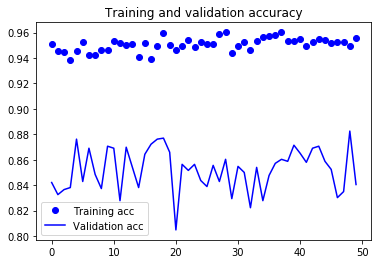

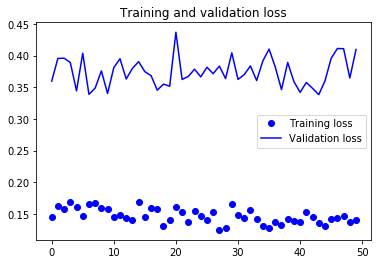

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [0]:
import pickle
import pickle
# save elmo_train_new
pickle_out = open("/content/drive/My Drive/paper works/elmo_history.pickle","wb")
pickle.dump(history, pickle_out)
pickle_out.close()

In [0]:
y.shape

(6298, 2)

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x1_train, x1_val,x2_train, x2_val,y_train, y_val =train_test_split(elmo_train_top,elmo_train_bm,y,test_size=0.2)
 

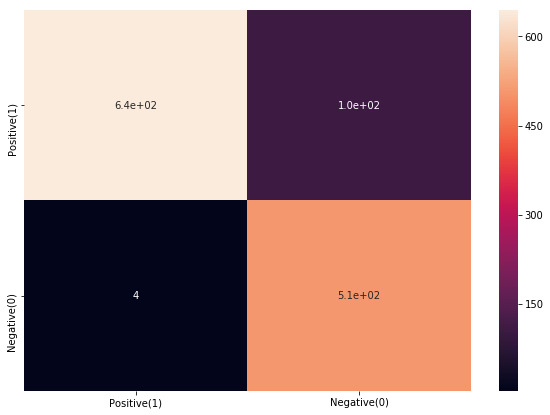

In [0]:
from sklearn import metrics
y_test=model.predict([x1_val,x2_val])
array= metrics.confusion_matrix(y_test.argmax(axis=1), y_val.argmax(axis=1))
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, index = [i for i in ["Positive(1)","Negative(0)"]],
                  columns = [i for i in ["Positive(1)","Negative(0)"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,)

In [0]:
# from sklearn.metrics import classification_report

In [0]:
# target_names=["fake","real"]

In [0]:
# print(classification_report(y_val, y_test, target_names=target_names))